In [1]:
import importlib.util
import sys
loc = '/afs/ciemat.es/user/m/martialc/public/muTel_v4/muTel/src/muTel/__init__.py'
# loc = r'..\..\..\src\muTel\__init__.py'
src = 'muTel'
spec = importlib.util.spec_from_file_location(src, loc)
foo = importlib.util.module_from_spec(spec)
sys.modules[src] = foo
spec.loader.exec_module(foo)
%load_ext autoreload

In [2]:
from IPython.display import display
import numpy as np
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import json
import matplotlib.pyplot as plt
import matplotlib as mpl
import pyarrow.parquet as pq
import pyarrow as pa
import os
from timeit import default_timer as timer
from scipy.optimize import curve_fit

import muTel.utils.meta as meta
from muTel.utils.tools import flatten_dict
from muTel.utils.units import Time

from muTel.dqm.classes.MuData import MuData
from muTel.dqm.classes.MuEvent import MuEvent

In [3]:
df = pd.read_parquet('../muses/run_588_test.parquet')
muse_table = df.set_index('MuSEId').loc['220C']

In [4]:
nhits = df.groupby('MuSEId').apply(lambda grp: len(grp))

/tmp/ipykernel_13145/946134347.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  nhits = df.groupby('MuSEId').apply(lambda grp: len(grp))


In [5]:
muse_4hits = nhits[nhits==4]

710.0


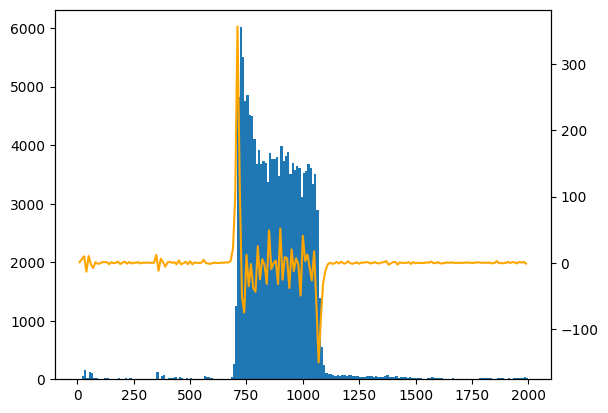

In [9]:
dt_sl1_l1 = df[(df['sl'] == 4)]['DriftTime']

cts, bins, _= plt.hist(dt_sl1_l1,range = (0,2000), bins = 200)
mids = (bins[1:]+bins[:-1])/2
dcts = np.diff(cts)/(bins[1]-bins[0])
dmids = (mids[1:]+mids[:-1])/2
ax2 = plt.gca().twinx()
ax2.plot(dmids,dcts,color='orange')
t0 = dmids[dcts.argmax()]
print(t0)

In [6]:
def find_max(data, range = (0,100), bins = 100):
    cts, edges = np.histogram(data,range=range, bins=bins)
    mids = 0.5*(edges[:-1]+edges[1:])
    return mids[cts.argmax()]

In [7]:
muse_4h = df.set_index('MuSEId').loc[nhits==4]
muse_4h = muse_4h[muse_4h.sl == 1]
dt = muse_4h['DriftTime'] - t0
mt1 = 0.5*(dt[muse_4h.layer == 1] + dt[muse_4h.layer == 3]) + dt[muse_4h.layer == 2]
mt2 = 0.5*(dt[muse_4h.layer == 2] + dt[muse_4h.layer == 4]) + dt[muse_4h.layer == 3]


range = (0,600)
bins = 150
mt = (find_max(mt1,range,bins) + find_max(mt2,range,bins))/2
print(find_max(mt1,range,bins),
find_max(mt2,range,bins),
mt)


# range = (300,450)
# range = (0,600)
# plt.style.use('ggplot')
# _ = plt.hist2d(mt1,mt2,range = (range,range), bins = 150, norm=mpl.colors.LogNorm(clip=True))
# plt.gca().set_aspect('equal')

# plt.show()
# _ = plt.scatter(mt1,mt2,s=3,alpha=0.05,color='k')
# plt.xlim(*range)
# plt.ylim(*range)
# plt.gca().set_aspect('equal')


NameError: name 't0' is not defined

In [7]:
muse_table = df.set_index('MuSEId').loc[muse_4hits.index[0]]
muse_table = muse_table.reset_index().set_index('layer')
muse_table

,MuSEId,EventNr,GEO,hit,channel,sl,cell,TDCtime,DriftTime
layer,,,,,,,,,
4,0A,0,24,4,20,1,6,1822,969.53125
3,0A,0,24,1,22,1,6,1698,872.65625
2,0A,0,24,2,21,1,6,1730,897.65625
1,0A,0,24,3,23,1,6,1741,906.25000


In [4]:
layers = [4,3,2,1]
cells = [0,-1,0,0]
ref_cell = cells[0]
# Convenio
# 4 a 1: RLR == [0, 0, 0, 0]
cell_shift = np.array(np.ceil(len(layers)/2).astype(int)*[0,0.5])[:len(layers)]
print(cells)
print(cells + cell_shift)

def pat_ID(cells):
    cells = cells + cell_shift
    cell_diff = np.diff(2*cells).astype(int)
    return ''.join(['R' if (diff == 1) else 'L' for diff in cell_diff])

pat_ID(muse_table.cell)

[0, -1, 0, 0]
[ 0.  -0.5  0.   0.5]


'RLR'

In [5]:
pat_dict = {
    "RLR": {
        "lats" : [
            "LLRL",
            "RLRL",
            "LLRR",
            "RLRR"
        ],
        "id" : "+A"
    },
    "LRL": {
        "lats" : [
            "RRLR",
            "LRLR",
            "RRLL",
            "LRLL"
        ],
        "id" : "-A"
    },
    "RLL": {
        "lats" : [
            "RLLL",
            "RLLR",
            "RLRR"
        ],
        "id" : "+B"
    },
    "LRR": {
        "lats" : [
            "LRRR",
            "LRRL",
            "LRLL"
        ],
        "id" : "-B"
    },
    "RRL": {
        "lats" : [
            "LLLR",
            "RLLR",
            "RRLR"
        ],
        "id" : "+C"
    },
    "LLR": {
        "lats" : [
            "RRRL",
            "LRRL",
            "LLRL"
        ],
        "id" : "-C"
    },
    "RRR": {
        "lats" : [
            "LLLL",
            "RRRR",
            "LLRR",
            "RRLL",
            "LLLR",
            "RRRL"
        ],
        "id" : "+D"
    },
    "LLL": {
        "lats" : [
            "RRRR",
            "LLLL",
            "RRLL",
            "LLRR",
            "RRRL",
            "LLLR"
        ],
        "id" : "-D"
    }
}
lat_dict = {
    "LLLL": [
        -1,
        -1,
        -1,
        -1
    ],
    "LLLR": [
        -1,
        -1,
        -1,
        1
    ],
    "LLRL": [
        -1,
        -1,
        1,
        -1
    ],
    "LLRR": [
        -1,
        -1,
        1,
        1
    ],
    "LRLL": [
        -1,
        1,
        -1,
        -1
    ],
    "LRLR": [
        -1,
        1,
        -1,
        1
    ],
    "LRRL": [
        -1,
        1,
        1,
        -1
    ],
    "LRRR": [
        -1,
        1,
        1,
        1
    ],
    "RLLL": [
        1,
        -1,
        -1,
        -1
    ],
    "RLLR": [
        1,
        -1,
        -1,
        1
    ],
    "RLRL": [
        1,
        -1,
        1,
        -1
    ],
    "RLRR": [
        1,
        -1,
        1,
        1
    ],
    "RRLL": [
        1,
        1,
        -1,
        -1
    ],
    "RRLR": [
        1,
        1,
        -1,
        1
    ],
    "RRRL": [
        1,
        1,
        1,
        -1
    ],
    "RRRR": [
        1,
        1,
        1,
        1
    ]
}

In [15]:
height = 13
width = 2*21
v0 = 55e-3

# heights = -height*(0.5+np.arange(len(layers)))
heights = height*(1.5-np.arange(len(layers)))

In [7]:
from scipy.optimize import curve_fit

In [36]:
heights

array([ 19.5,   6.5,  -6.5, -19.5])


LLRL
v_drift:	55.00 um/ns
t0:     	670.7 ns
phi:    	-0.08π (-14.48º) ()
x0:     	0.03·width
chi2:   	0.024



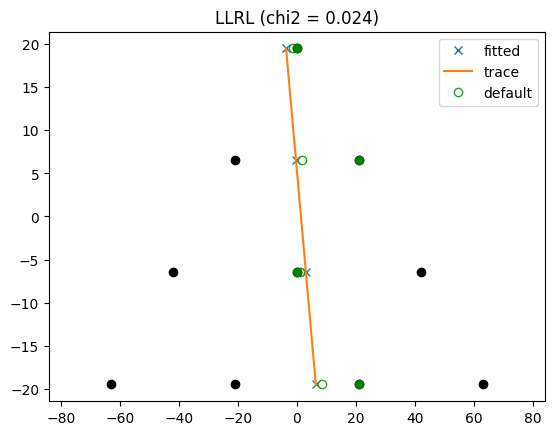


RLRL
v_drift:	55.00 um/ns
t0:     	687.9 ns
phi:    	-0.04π (-6.83º) ()
x0:     	0.08·width
chi2:   	7.130



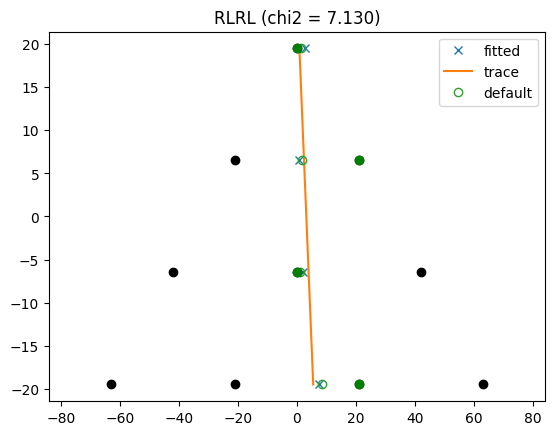


LLRR
v_drift:	55.00 um/ns
t0:     	539.5 ns
phi:    	-0.30π (-53.99º) ()
x0:     	0.21·width
chi2:   	186.507



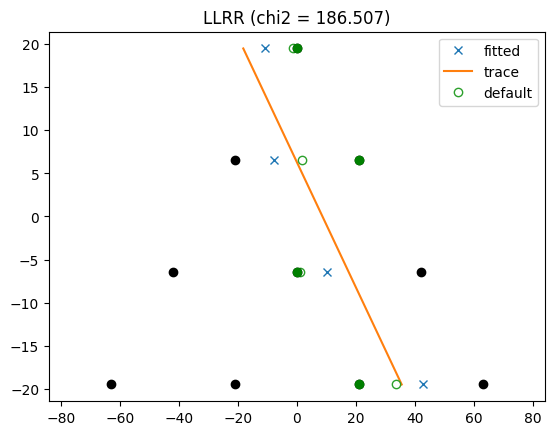


RLRR
v_drift:	55.00 um/ns
t0:     	747.5 ns
phi:    	-0.19π (-34.96º) ()
x0:     	0.20·width
chi2:   	23.565



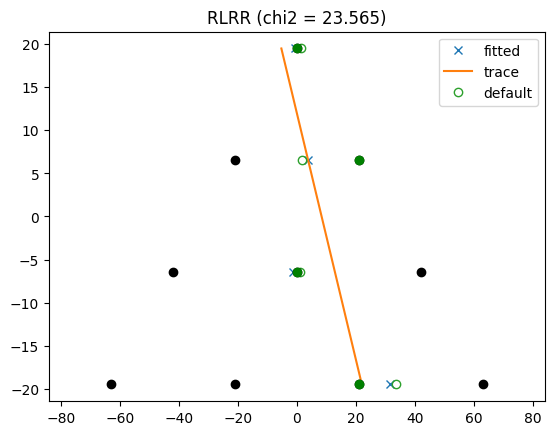

In [18]:
# n_muse = 2

# muse_table = df.set_index('MuSEId').loc[muse_4hits.index[n_muse]]
# muse_table = muse_table.reset_index().set_index('layer')
# display(muse_table)


ref_cell    = muse_table.iloc[0]['cell']
# display(ref_cell)
rel_cell    = muse_table['cell'] + cell_shift - ref_cell
# display(rel_cell)

height = 13
width = 2*21
v0 = 55e-3
v = v0
patID = pat_ID(muse_table.cell)
# lats = [lat_dict[lat] for lat in pat_dict[patID]['lats']]

def inv_trace(x, tan, x0, t0):
    y   = x[0]
    c   = x[1]
    return y*tan+x0+c*v*t0



for i, lat_id in enumerate(pat_dict[patID]['lats']):
    lat = np.array(lat_dict[lat_id])
    print(f'\n{lat_id}')
    x = np.zeros((3,len(layers)))
    x[0] = heights
    x[1] = lat

    (tan, x0, t0), cov = curve_fit(inv_trace,x,(rel_cell*width + lat*v*muse_table.DriftTime),
                               p0 = [0, 0, 710],
                               bounds = [
                                    [-width/height, -width/2, 0],
                                    [ width/height,  width/2, np.inf],
                               ],
                               maxfev = 10000
                            )
    theta = np.arctan(tan)
    x_obvs = rel_cell*width + lat*v*(muse_table.DriftTime-t0)
    x_expc = x0 + heights*tan
    res = x_obvs - x_expc
    chi2 = np.sum(res**2/np.abs(x_expc))
    print(
        f'v_drift:\t{v*1e3:2.2f} um/ns\n'
        f't0:     \t{t0:3.1f} ns\n'
        f'phi:    \t{theta/np.pi:.2f}π ({180*theta/np.pi:.2f}º) ()\n'
        f'x0:     \t{x0/width:.2f}·width\n'
        f'chi2:   \t{chi2:.3f}\n'
    )
    plt.plot(
        x_obvs,
        heights,
        linestyle='none',
        marker = 'x',
        label='fitted'
    )
    plt.plot(
        x_expc,
        heights,
        linestyle='solid',
        marker = 'none',
        label='trace'
    )
    plt.plot(
        (muse_table.DriftTime-710)*lat*v0+rel_cell*width,
        heights,
        linestyle='none',
        marker = 'o',
        label = 'default',
        mfc='none'
    )
    wires_x = 0.5*width*np.r_[[0],[-1,1],[-2,0,2],[-3,-1,1,3]]
    wires_y = np.r_[heights[0],np.repeat(heights[1],2),np.repeat(heights[2],3),np.repeat(heights[3],4)]
    plt.plot(
        wires_x,
        wires_y,
        linestyle='none',
        marker = 'o',
        color = 'k'
    )
    plt.plot(
        rel_cell*width,
        heights,
        linestyle='none',
        marker = 'o',
        color = 'green'
    )
    plt.legend()
    plt.xlim(-2*width,2*width)
    plt.title(f'{lat_id} (chi2 = {chi2:.3f})')
    plt.show()


LLRL
v_drift:	55.00 um/ns
t0:     	670.7 ns
phi:    	-0.08π (-14.48º)
x0:     	0.03·width
chi2:   	0.024



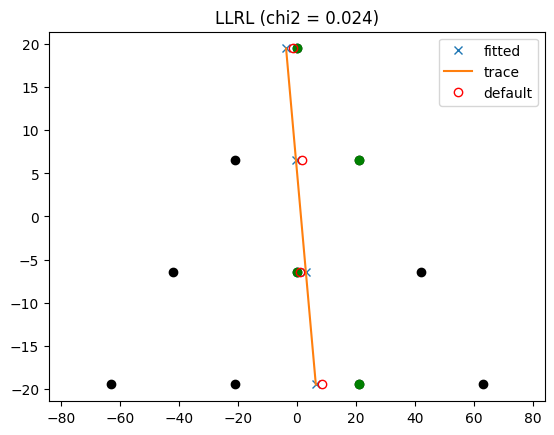


RLRL
v_drift:	55.00 um/ns
t0:     	687.9 ns
phi:    	-0.04π (-6.83º)
x0:     	0.08·width
chi2:   	7.130



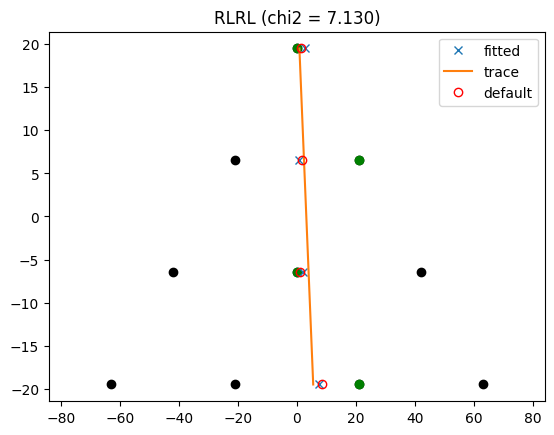


LLRR
v_drift:	55.00 um/ns
t0:     	539.5 ns
phi:    	-0.30π (-53.99º)
x0:     	0.21·width
chi2:   	186.507



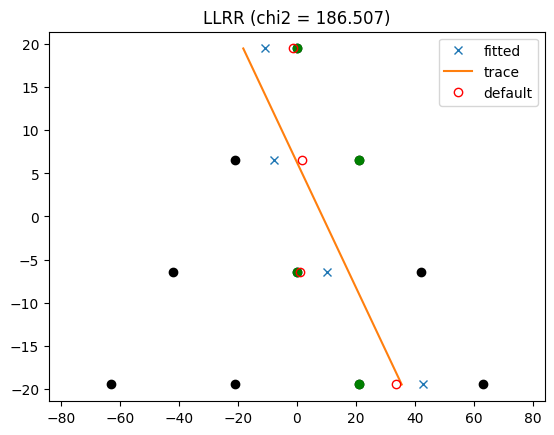


RLRR
v_drift:	55.00 um/ns
t0:     	747.5 ns
phi:    	-0.19π (-34.96º)
x0:     	0.20·width
chi2:   	23.565



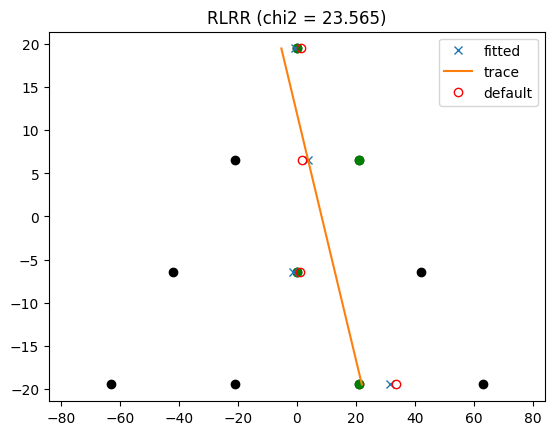

In [41]:

# n_muse = 2

# muse_table = df.set_index('MuSEId').loc[muse_4hits.index[n_muse]]
# muse_table = muse_table.reset_index().set_index('layer')
# display(muse_table)


ref_cell    = muse_table.iloc[0]['cell']
# display(ref_cell)
rel_cell    = muse_table['cell'] + cell_shift - ref_cell
# display(rel_cell)

height = 13
width = 2*21
v0 = 55e-3
v = v0
patID = pat_ID(muse_table.cell)
# lats = [lat_dict[lat] for lat in pat_dict[patID]['lats']]

def inv_trace(x, theta, x0, t0):
    y   = x[0]
    c   = x[1]
    x_n = x[2]
    v   = x[3]
    return c/v*(y*np.tan(theta)-x_n+x0)+t0



for i, lat_id in enumerate(pat_dict[patID]['lats']):
    lat = np.array(lat_dict[lat_id])
    print(f'\n{lat_id}')
    x = np.zeros((4,len(layers)))
    x[0] = heights
    x[1] = lat
    x[2] = rel_cell * width
    x[3] = v0
    

    (theta, x0, t0), cov = curve_fit(inv_trace,x,muse_table.DriftTime,
                               p0 = [0, 0, 710],
                               bounds = [
                                    [np.arctan(-width/height), -width/2, 0],
                                    [np.arctan( width/height),  width/2, np.inf],
                               ],
                               maxfev = 10000
                            )
    tan = np.tan(theta)
    x_obvs = rel_cell*width + lat*v*(muse_table.DriftTime-t0)
    x_expc = x0 + heights*tan
    res = x_obvs - x_expc
    chi2 = np.sum(res**2/np.abs(x_expc))
    print(
        f'v_drift:\t{v*1e3:2.2f} um/ns\n'
        f't0:     \t{t0:3.1f} ns\n'
        f'phi:    \t{theta/np.pi:.2f}π ({np.rad2deg(theta):.2f}º)\n'
        f'x0:     \t{x0/width:.2f}·width\n'
        f'chi2:   \t{chi2:.3f}\n'
    )
    plt.plot(
        x_obvs,
        heights,
        linestyle='none',
        marker = 'x',
        label='fitted'
    )
    plt.plot(
        x_expc,
        heights,
        linestyle='solid',
        marker = 'none',
        label='trace'
    )
    plt.plot(
        (muse_table.DriftTime-710)*lat*v0+rel_cell*width,
        heights,
        linestyle='none',
        marker = 'o',
        label = 'default',
        mfc='none',
        color='red'
    )
    wires_x = 0.5*width*np.r_[[0],[-1,1],[-2,0,2],[-3,-1,1,3]]
    wires_y = np.r_[heights[0],np.repeat(heights[1],2),np.repeat(heights[2],3),np.repeat(heights[3],4)]
    plt.plot(
        wires_x,
        wires_y,
        linestyle='none',
        marker = 'o',
        color = 'k',
        zorder=-2
    )
    plt.plot(
        rel_cell*width,
        heights,
        linestyle='none',
        marker = 'o',
        color = 'green',
        zorder=-1
    )
    plt.legend()
    plt.xlim(-2*width,2*width)
    plt.title(f'{lat_id} (chi2 = {chi2:.3f})')
    plt.show()